Author: James Dutfield

Date: 14/09/23

Personal project to learn about credit risk as an ML problem. 

This notebook is only intended to be a brief experiment to reach a baseline ML model performance, and largely skips through many of the usual steps of a data science project (EDA, feature analysis etc).

The KNN produced the best baseline results with the a 63% loan acceptance rate and a 2.6% default rate.

# Task 1

In [1]:
# import libraries

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

#import customs
from config import *
from util import *

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# preproc
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# models & metrics
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay

In [2]:
# import data
features = pd.read_csv("features.csv")
targets = pd.read_csv("targets.csv")

## Model Consideration & Research

Quick research relating to how industry tackles credit risk problems to help inform model choices.

Problem description: Supervised classification on a relatively small dataset (10,000)

Model Choices for Assignment:
- Logistic regression - I will almost always use this as my first model for supervised classification problems
- KNN - often used for credit risk problems and typically performs well on datasets of this size.
- XGBoost - best performance for credit risk on the same number of samples as per source (https://www.sciencedirect.com/science/article/pii/S1877050922001442).

For these models, the most important evaluation metrics will be related to:
- Recall: false negatives need to be low because of the high cost incurred when a customer defaults on their loan
- Precision: false positives also need to be considered due to the cost of losing a customer due to flagging them as too high risk

The optimal balance of precision & recall is out of scope (although recall is more important due to the relative cost of a customer defaulting hugely outweighing the profit of a successful contract completion).


## First Look

In [3]:
features.head()

,customer_id,application_date,gender,unsatisfied_ccjs,age_oldest_active_account,cc_value_3m,worst_paystatus_24m,defaults,months_since_default,search_payday,deceased
0,0,26/03/2019,M,0.0,190.0,NaN,D,14.0,19.0,0.0,0.0
1,1,29/03/2019,F,0.0,30.0,NaN,D,2.0,1.0,0.0,0.0
2,2,11/03/2019,F,0.0,39.0,NaN,U,1.0,31.0,0.0,0.0
3,3,07/06/2017,M,0.0,9.0,NaN,0,0.0,NaN,0.0,0.0
4,4,11/06/2017,F,0.0,121.0,NaN,U,2.0,46.0,0.0,0.0


In [4]:
features.describe()

,customer_id,unsatisfied_ccjs,age_oldest_active_account,cc_value_3m,defaults,months_since_default,search_payday,deceased
count,10000.00000,9997.000000,9878.000000,1226.000000,9975.000000,6380.000000,9975.000000,9975.000000
mean,4999.50000,0.436831,121.554566,473.814029,2.317293,29.580878,0.207218,0.002105
std,2886.89568,0.862110,71.547785,736.933828,2.912479,19.149969,0.828645,0.045837
min,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2499.75000,0.000000,72.000000,87.250000,0.000000,13.000000,0.000000,0.000000
50%,4999.50000,0.000000,110.000000,246.000000,1.000000,27.000000,0.000000,0.000000
75%,7499.25000,1.000000,157.000000,524.500000,4.000000,44.000000,0.000000,0.000000
max,9999.00000,9.000000,746.000000,6232.000000,24.000000,71.000000,15.000000,1.000000


# Initial thoughts looking at table & describe()


- application date: can be broken into days of week, week of month, month of year etc
- gender: encoding required (depending on model)
- unsatisfied_ccjs: potential scaling/normalizing required depending on model used
- age_oldest_active_account: potential scaling/normalizing required depending on model used
- cc_value_3m: lots of NaNs. To replace NaNs with zeros on the assumption that in practice NaN is left over from the join used and means no accounts.
- worst_paystatus_24m: Encoding required (depending on model), possibly multiple types
- months_since_default: NaN when default = 0.0
- search_payday: potential scaling/normalizing required depending on model used
- deceased: Unsure on context. Initially interested to see if it results in defaults 100% of the time, in which case I would consider removing this from the model and having a rule that rejects all deceased=1.0 applications before it reaches the model. A quick check showed that deceased applications default less that 100% of the time, so the feature will be included going forward.

# Missing Number Check

In [5]:
### Missing number check

features.isnull().sum()

customer_id                     0
application_date                0
gender                         85
unsatisfied_ccjs                3
age_oldest_active_account     122
cc_value_3m                  8774
worst_paystatus_24m           111
defaults                       25
months_since_default         3620
search_payday                  25
deceased                       25
dtype: int64

### Handling missing values

Required for logistic regression & KNN models only.

It may be appropriate to reject some credit applications before they reach the model if data is missing across multiple fields (giving us not enough information to evaluate the risk of that user). 

I will go forward assuming that this will NOT be the case, and that every application must pass through the model.

In practice, these NaNs would be investigated to find the cause/context and then decide the appropriate action to take. However in this case I will take the following actions:

Impute column mean:
- gender
- unsatisfied_ccjs -> low count
- Defaults
- Deceased
- Search_payday

Impute zeros:
- CC_value_3m -> as discussed earlier
- age_oldest_account -> perhaps because they have not had an account prior. If that's the case there is scope to add an addition field called 'first_account'->{1,0}

Other:
- worst_payment_status_24m -> convert all 'U' into NaN, encode column, and then impute column 'average'
- Months_since_default -> difficult to deal with since NaN occurs on all cases where defaults=0.0. Considered replacing with -1, but that might trick the model into thinking that it was a 'very recent' default. Instead I will opt to impute a large number, slightly larger than the previous biggest in the dataset.


In [6]:
# with reference to comment above. Largest number for months since default is 71.0. 
# Will set 100.0 as the imputed replacement for missing values for this column.
max(features['months_since_default'])

71.0

# Distribution of Target Variable

In [7]:
nd_count, d_count = list(targets['target'].value_counts())
print("Defaults: " + str(d_count))
print("No Default: " + str(nd_count))
print("Defaults account for: " + str((d_count/(nd_count+d_count))*100) + "% of the dataset")

Defaults: 1686
No Default: 8314
Defaults account for: 16.86% of the dataset


### Positive skew in target variable means that some form of oversampling would be appropriate.

# Configure Preproc Transformations and Pipeline

In [8]:
# Individual transformer classes and column mappings taken from util.py and config.py

EncodeAndMissingValues = ColumnTransformer(transformers=[
    ("EncodePaymentStatus", EncodePaymentStatusAndImputeMean(), encode_payment_status_cols),
    ("EncodeOrdinal", EncodeGenderAndImputeMean(), encode_ordinal_cols), 
    ("Impute_Zeros", ImputeZeros(), impute_zero_cols),
    ("Impute_Mean", ImputeMean(), impute_average_cols),
    ('Impute_100', ImputeHundred(), impute_100_cols),
    ('returnFloat', returnFloat(), date_cols)
])

In [9]:
# train / test split
features = features.drop(columns=['customer_id'])
targets = targets.drop(columns=['customer_id'])
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.30, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(features, targets, test_size=0.15, random_state=66, shuffle=True)

In [10]:
# oversample training dataset to balance target variable to 50%
ros = RandomOverSampler(random_state=42, sampling_strategy=1.0)
X_train, y_train = ros.fit_resample(X_train, y_train)
print(y_train.value_counts())

target
0.0       7040
1.0       7040
Name: count, dtype: int64


# Train Models

In [11]:
# logistic regression

lr = Pipeline([
    ('encode_dates', DataframeFunctionTransformer(EncodeDates)),
    ('encode_columns_and_handle_missing_values', EncodeAndMissingValues),
    #('debug',Debug()),
    ('standard_scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=0))
])

lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

In [12]:
# knn

knn = Pipeline([
    ('encode_dates', DataframeFunctionTransformer(EncodeDates)),
    ('encode_columns_and_handle_missing_values', EncodeAndMissingValues),
    ('standard_scaler', StandardScaler()),
    ('model', KNeighborsClassifier())
])

knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

In [13]:
# xgboost

XGB = Pipeline([
    ('encode_dates', DataframeFunctionTransformer(EncodeDates)),
    ('encode_columns_and_handle_missing_values', EncodeAndMissingValues), # categorical not supported yet for classifier
    ('model', xgb.XGBClassifier(n_estimators=200, learning_rate=0.03, eval_metric='auc'))
])

XGB.fit(X_train, y_train)
XGB_pred = XGB.predict(X_test)

# Evaluate Models

In [14]:
# All negative predictions are "accepted applications"
# False negatives are the accepted applications that then default

print("Logistic Regression Report:")
tn, fp, fn, tp = confusion_matrix(y_test, lr_pred).ravel()
print("tn = " + str(tn))
print("fp = " + str(fp))
print("fn = " + str(fn))
print("tp = " + str(tp))
print("Model accepts this percentage of applications: " + str(((fn+tn)/(tn+fp+fn+tp))*100))
print("Of those accepted, this percentage will default: " + str((fn/(tn+fn))*100))
print(' ')

print("KNN Report:")
tn, fp, fn, tp = confusion_matrix(y_test, knn_pred).ravel()
print("tn = " + str(tn))
print("fp = " + str(fp))
print("fn = " + str(fn))
print("tp = " + str(tp))
print("Model accepts this percentage of applications: " + str(((fn+tn)/(tn+fp+fn+tp))*100))
print("Of those accepted, this percentage will default: " + str((fn/(tn+fn))*100))
print(' ')

tn, fp, fn, tp
print("XGB Report:")
tn, fp, fn, tp = confusion_matrix(y_test, XGB_pred).ravel()
print("tn = " + str(tn))
print("fp = " + str(fp))
print("fn = " + str(fn))
print("tp = " + str(tp))
print("Model accepts this percentage of applications: " + str(((fn+tn)/(tn+fp+fn+tp))*100))
print("Of those accepted, this percentage will default: " + str((fn/(tn+fn))*100))

Logistic Regression Report:
tn = 1633
fp = 834
fn = 181
tp = 352
Model accepts this percentage of applications: 60.46666666666667
Of those accepted, this percentage will default: 9.977949283351709
 
KNN Report:
tn = 1848
fp = 619
fn = 50
tp = 483
Model accepts this percentage of applications: 63.26666666666667
Of those accepted, this percentage will default: 2.634351949420443
 
XGB Report:
tn = 1973
fp = 494
fn = 137
tp = 396
Model accepts this percentage of applications: 70.33333333333334
Of those accepted, this percentage will default: 6.492890995260664


In [15]:
print("Logistic Regression Report:")
print(classification_report(y_test, lr_pred))
print(' ')

print("KNN Report:")
print(classification_report(y_test, knn_pred))
print(' ')

print("XGB Report:")
print(classification_report(y_test, XGB_pred))

Logistic Regression Report:
              precision    recall  f1-score   support

         0.0       0.90      0.66      0.76      2467
         1.0       0.30      0.66      0.41       533

    accuracy                           0.66      3000
   macro avg       0.60      0.66      0.59      3000
weighted avg       0.79      0.66      0.70      3000

 
KNN Report:
              precision    recall  f1-score   support

         0.0       0.97      0.75      0.85      2467
         1.0       0.44      0.91      0.59       533

    accuracy                           0.78      3000
   macro avg       0.71      0.83      0.72      3000
weighted avg       0.88      0.78      0.80      3000

 
XGB Report:
              precision    recall  f1-score   support

         0.0       0.94      0.80      0.86      2467
         1.0       0.44      0.74      0.56       533

    accuracy                           0.79      3000
   macro avg       0.69      0.77      0.71      3000
weighted avg      

### KNN is the best model

Despite having a slightly lower accuracy than XGBoost (KNN = 0.78 vs XGBoost = 0.79) the precision for negative labels is far better for KNN which leads to fewer defaults on accepted loan applications.

Of applications accepted, only 2.6% will default for KNN, compared to 6.5% for XGBoost and 10% for Logistic Regression. This is the most important metric to consider.

There is a balance that needs to me made between the number of applications accepted and the default rate. In principle, the more loans you accept the higher your revenue, but the higher the default rate the more the defaults eat into your profits. The XGBoost model accepts 7% more loans than the KNN model (70% vs 63% respectively), however it has a 270% higher default rate. 

This means that despite accepting fewer loan applications, a service using the KNN model will be vastly more profitable than for the XGBoost model (except perhaps if the service is high volume, low value, high interest loans, e.g payday loans).

For a commercial model the acceptance rate and default rate would need to be better, however as a first try on a small dataset, I'm happy with the results. 

              precision    recall  f1-score   support

         0.0       0.98      0.77      0.86      7040
         1.0       0.81      0.98      0.89      7040

    accuracy                           0.88     14080
   macro avg       0.89      0.88      0.87     14080
weighted avg       0.89      0.88      0.87     14080



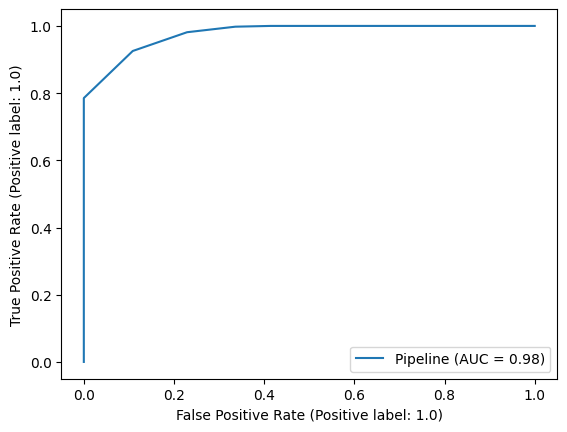

In [16]:
custom_model_eval(knn, X_train, y_train)

              precision    recall  f1-score   support

         0.0       0.97      0.75      0.85      2467
         1.0       0.44      0.91      0.59       533

    accuracy                           0.78      3000
   macro avg       0.71      0.83      0.72      3000
weighted avg       0.88      0.78      0.80      3000



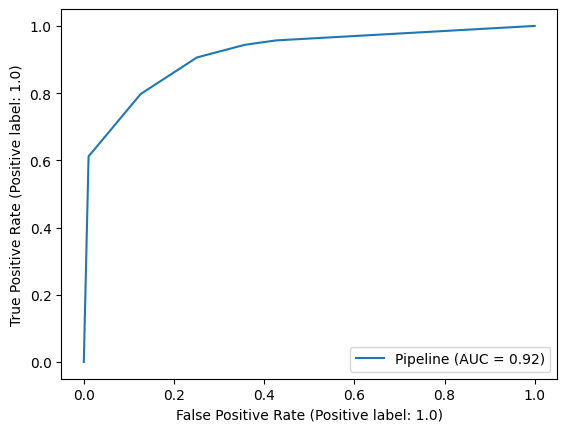

In [17]:
custom_model_eval(knn, X_test, y_test)

Analysing the KNN model further, the roc curves above show reasonably impressive results, with a AUC of 0.92 on the test dataset.

There is a slight overfit with the training score achieving an auc of 0.98 compared to 0.92 for the test dataset. This will be improved upon with hyperparameter tuning, cross-validation and using a larger dataset.

f0: worst_paystatus_24m
f1: gender
f2: cc_value_3m
f3: dayofmonth
f4: unsatisfied_ccjs
f5: defaults
f6: search_payday
f7: deceased
f8: months_since_default
f9: dayofweek
f10: dayofmonth
f11: month
f12: year


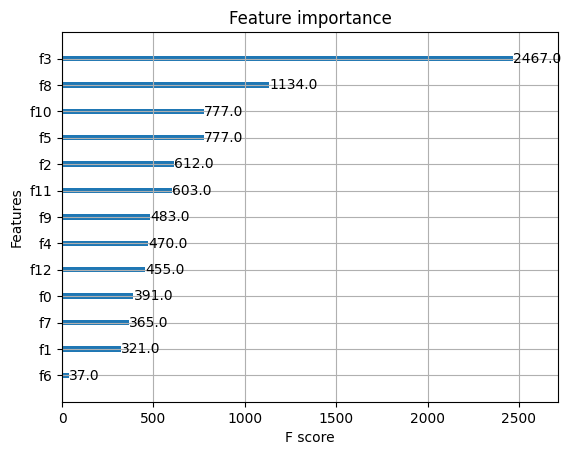

<Figure size 1600x1200 with 0 Axes>

In [18]:
feature_importance(XGB, feature_order)

Above is a view of feature importance for the XGBoost model. Although KNN was the best model, it can be interesting to view model feature importance - and XGBoost has great built in tools for this due to being a tree-based approach.

It can be seen that the day of the month that the application was made, and the months since last default are the best indicators for whether or not someone is likely to default on their loan.

### Optimising XGBoost 

This was an an additional experiment to see if XGBoost could be optimised to beat the KNN model, however it didn't yield any significant improvement.

In [ ]:
# this cell may take some time to run

XGB = Pipeline([
    ('encode_dates', DataframeFunctionTransformer(EncodeDates)),
    ('encode_columns_and_handle_missing_values', EncodeAndMissingValues), # categorical not supported yet for classifier
    ('model', xgb.XGBClassifier(n_estimators=200, learning_rate=0.03, objective='binary:logistic'))
])

parameters = {
    'model__max_depth': [3, 4, 5],
    'model__n_estimators': [100, 150, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__alpha': [0, 2, 5, 10]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=12)
GS = HalvingGridSearchCV(estimator=XGB, param_grid=parameters, cv=cv, scoring='roc_auc', min_resources='exhaust', verbose=False) #,error_score=0

GS.fit(X_train, y_train)

print(GS.best_estimator_.get_params()['model'])
print(" ")
print("XGB Report:")
best_XGB = GS.best_estimator_
XGB_pred = best_XGB.predict(X_test)
print(classification_report(y_test, XGB_pred))

In [ ]:
results = best_XGB[2].evals_result()
custom_learning_curve(results)

In [ ]:
custom_model_eval(final_XGB, X_test, y_test)

In [ ]:
custom_model_eval(XGB, X_train, y_train)

In [ ]:
custom_model_eval(XGB, X_test, y_test)

# Next Steps

- EDA & feature analysis
- Model fine tuning including
- Using a larger dataset
- Look to incorporate more data fields
- It might prove effective to use GANs to upsample the dataset before training on XGBoost, as shown in the following paper https://www.tandfonline.com/doi/full/10.1080/08839514.2021.1987707
- KNN Imputer to deal with missing values.
- Experiment with unsupervised techniques.